# Task 1: Fine-tune Chemical Language Model

The goal is to fine-tune a pre-trained chemical language model on a regression task using the Lipophilicity dataset. The task involves predicting the lipophilicity value for a given molecule representation (SMILES string). You will learn how to load and tokenize a dataset from HuggingFace, how to load a pre-trained language model, and finally, how to run a model in inference mode.

Your task is to complete the missing code blocks below.

In [251]:
# import dependencies
import torch
from datasets import load_dataset
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm.notebook import tqdm
import random

# 1.Fine-tune a Chemical Language Model on Lipophilicity


## --- Step 1: Load Dataset ---

The dataset we are going to use is the [Lipophilicity](https://huggingface.co/datasets/scikit-fingerprints/MoleculeNet_Lipophilicity) dataset, part of [MoleculeNet](https://pubs.rsc.org/en/content/articlelanding/2018/sc/c7sc02664a) benchmark.

Lipophilicity, also known as hydrophobicity, is a measure of how readily a substance dissolves in nonpolar solvents (such as oil) compared to polar solvents (such as water).

In [257]:
# specify dataset name and model name
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"  #MoLFormer model

In [259]:
# load the dataset from HuggingFace
dataset = load_dataset(DATASET_PATH)

In [261]:
# Explore the dataset
# For example, print the column names and display a few sample rows
# TODO: your code goes here

print(dataset)
print(dataset.keys())#Hugging face datasets are stored in DatasetDict, which have different keys usually like 'train','test','validation'.
print(dataset['train'].features)#View datatypes of columns
print(dataset['train'][:5]) #View first 5 rows


DatasetDict({
    train: Dataset({
        features: ['SMILES', 'label'],
        num_rows: 4200
    })
})
dict_keys(['train'])
{'SMILES': Value(dtype='string', id=None), 'label': Value(dtype='float64', id=None)}
{'SMILES': ['Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', 'COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23', 'COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl', 'OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(Cl)sc4[nH]3', 'Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)NCC#N)c1'], 'label': [3.54, -1.18, 3.69, 3.37, 3.1]}


In [263]:
class SMILESDataset(Dataset):
    def __init__(self, dataset):

        self.smiles = dataset['SMILES']  # Extract SMILES strings
        self.label = torch.tensor(dataset['label'], dtype=torch.float32)  # Convert labels to tensor
        

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, index):
        smiles = self.smiles[index]
        label = self.label[index]
        return {'smiles': smiles, 'label': label}

## --- Step 2: Split Dataset ---

As there is only one split (train split) in the original dataset, we need to split the data into training and testing sets by ourselves.

In [266]:
# tokenize the data
# load a pre-trained tokenizer from HuggingFace
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

In [268]:
# split the data into training and test datasets
# TODO: your code goes here

train_test_split = dataset["train"].train_test_split(test_size=0.25)  # 75% train, 25% test


train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

In [270]:
print(len(test_dataset))
print(len(train_dataset))
print(len(test_dataset)+len(train_dataset))

1050
3150
4200


In [272]:
# construct Pytorch data loaders for both train and test datasets
BATCH_SIZE = 16 # adjust based on memory constraints

# TODO: your code goes here

# Create the PyTorch datasets for train and test using the SMILESDataset class
train_smiles_dataset = SMILESDataset(train_dataset)
test_smiles_dataset = SMILESDataset(test_dataset)

# Construct DataLoaders for both train and test datasets
train_dataloader = DataLoader(train_smiles_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_smiles_dataset, batch_size=BATCH_SIZE, shuffle=False)

## --- Step 3: Load Model ---

In [275]:
# load pre-trained model from HuggingFace
model = AutoModel.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True)

In [276]:
class MoLFormerWithRegressionHead(nn.Module):
    # TODO: your code goes here

    def __init__(self, model, input_dim, output_dim = 1):
        super(MoLFormerWithRegressionHead, self).__init__()
        self.model = model
        self.linear_output = torch.nn.Linear(input_dim, output_dim, bias=True)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids, attention_mask)
        if hasattr(outputs, 'last_hidden_state'):
          last_hidden_state = outputs.last_hidden_state
        elif hasattr(outputs, 'logits'):  # Some models (masked models) have 'logits' instead
          last_hidden_state = outputs.logits
 
        cls_output = last_hidden_state[:, 0, :] # Take the first token
        output = self.linear_output(cls_output)
        return output

In [277]:
# initialize the regression model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model = MoLFormerWithRegressionHead(model, 768).to(device)

## --- Step 4: Training --- AND --- Step 5: Evaluation ---

In [290]:
import torch.optim as optim

# Loss function (Mean Squared Error)
criterion = torch.nn.MSELoss()

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.0001)  
epochs = 5

In [292]:
# Splitting the dataset for validation
train_val_split = train_test_split["train"].train_test_split(test_size=0.1)  # 90% train, 10% validation
train_dataset = train_val_split["train"]
val_dataset = train_val_split["test"]

# Construct DataLoader for validation
val_smiles_dataset = SMILESDataset(val_dataset)
val_dataloader = DataLoader(val_smiles_dataset, batch_size=BATCH_SIZE, shuffle=False)

Epoch [1/5], Train Loss: 1.4559, Val Loss: 1.4332
Model saved successfully at molformer_regression.pth
Epoch [2/5], Train Loss: 1.4589, Val Loss: 1.4332
Epoch [3/5], Train Loss: 1.4589, Val Loss: 1.4312
Model saved successfully at molformer_regression.pth
Epoch [4/5], Train Loss: 1.4451, Val Loss: 1.4489
Epoch [5/5], Train Loss: 1.4525, Val Loss: 1.4579
Final Test Loss: 1.5213


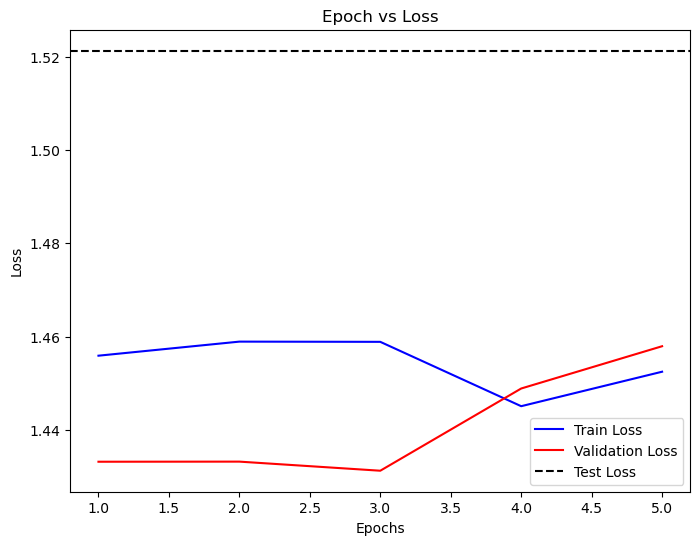

In [305]:
import matplotlib.pyplot as plt
import numpy as np

def train_with_early_stopping(train_dataloader, val_dataloader, test_dataloader, epochs, optimizer, criterion, model, tokenizer, device, patience=5):
    model.train()  # Set model to training mode
    
    train_losses = []
    val_losses = []
    test_losses = []
    
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(int(epochs)):
        total_train_loss = 0
        for batch in train_dataloader:
            smiles = batch['smiles']
            smiles = tokenizer(smiles, padding=True, return_tensors='pt').to(device)
            label = batch['label'].reshape(len(batch['label']),1).to(device)

            optimizer.zero_grad()
            outputs = model(smiles['input_ids'], smiles['attention_mask'])

            loss = criterion(outputs, label)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                smiles = batch['smiles']
                smiles = tokenizer(smiles, padding=True, return_tensors='pt').to(device)
                label = batch['label'].reshape(len(batch['label']),1).to(device)

                outputs = model(smiles['input_ids'], smiles['attention_mask'])
                loss = criterion(outputs, label)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            torch.save(model.state_dict(), "molformer_regression.pth")
            print(f"Model saved successfully at {model_path}")
            best_val_loss = avg_val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping triggered!")
            break
        
        model.train()

    # Test phase
    model.load_state_dict(torch.load("molformer_regression.pth"))
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_dataloader:
            smiles = batch['smiles']
            smiles = tokenizer(smiles, padding=True, return_tensors='pt').to(device)
            label = batch['label'].reshape(len(batch['label']),1).to(device)
    
            outputs = model(smiles['input_ids'], smiles['attention_mask'])
            
            # Ensure output shape matches target shape
            loss = criterion(outputs, label)
            total_test_loss += loss.item()
    
    avg_test_loss = total_test_loss / len(test_dataloader)
    print(f"Final Test Loss: {avg_test_loss:.4f}")  # Explicitly print test loss
    
    # Plot losses
    plt.figure(figsize=(8,6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color='blue')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", color='red')
    plt.axhline(y=avg_test_loss, color='black', linestyle='--', label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Epoch vs Loss")
    plt.show()

# Train the model with early stopping
train_with_early_stopping(
    train_dataloader=train_dataloader, 
    val_dataloader=val_dataloader, 
    test_dataloader=test_dataloader, 
    epochs=epochs, 
    optimizer=optimizer, 
    criterion=criterion, 
    model=regression_model, 
    tokenizer=tokenizer, 
    device=device, 
    patience=3  # Adjust patience if needed
)


# 2.Add Unsupervised Finetuning
In this step, you will perform unsupervised fine-tuning on the training dataset. This means the model will leverage only the SMILES strings without any corresponding labels to adapt its understanding of the data distribution. By familiarizing the model with the patterns and structure of the SMILES strings, you can potentially enhance its performance on downstream supervised tasks.

For this fine-tuning, you will use the Masked Language Modeling (MLM) objective, where the model learns to predict randomly masked tokens within the input sequence. Remember to save the fine-tuned model for later use.


In [307]:
# TODO: your code goes here
from transformers import DataCollatorForLanguageModeling

# Define a data collator for MLM (Randomly masks some tokens in the input)
mlm_probability = 0.15  # 15% of tokens will be masked
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=mlm_probability
)

In [308]:
class UnsupervisedSMILESDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=128):
        self.smiles = dataset['SMILES']
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smiles_str = self.smiles[idx]

        # Tokenize SMILES string
        encoding = self.tokenizer(
            smiles_str,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # Extract tokenized input
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask
        }

# Create dataset instances
unsupervised_train_dataset = UnsupervisedSMILESDataset(train_dataset, tokenizer)
unsupervised_val_dataset = UnsupervisedSMILESDataset(val_dataset, tokenizer)
unsupervised_test_dataset = UnsupervisedSMILESDataset(test_dataset, tokenizer)

# Create DataLoaders
unsupervised_train_loader = DataLoader(unsupervised_train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
unsupervised_val_loader = DataLoader(unsupervised_val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)
unsupervised_test_loader = DataLoader(unsupervised_test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)

In [309]:
from transformers import AutoModelForMaskedLM

# Load pre-trained model for MLM
mlm_model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME, trust_remote_code=True).to(device)


In [310]:
LEARNING_RATE = 0.0001

In [311]:
import torch.optim as optim

# Define optimizer and loss function
optimizer = optim.AdamW(mlm_model.parameters(), lr=LEARNING_RATE)

# Training function for MLM
def train_mlm(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

# Evaluation function for MLM
def evaluate_mlm(model, test_loader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            total_loss += loss.item()

    return total_loss / len(test_loader)


In [312]:
import torch

MLM_EPOCHS = 3  # Adjust as needed
patience = 3  # Number of epochs to wait before stopping if no improvement
best_val_loss = float('inf')  # Track lowest validation loss
early_stop_counter = 0
best_model_path = "best_molformer_mlm_finetuned"

for epoch in range(MLM_EPOCHS):
    train_loss = train_mlm(mlm_model, unsupervised_train_loader, optimizer, device)
    val_loss = evaluate_mlm(mlm_model, unsupervised_val_loader, device)

    print(f"Epoch {epoch+1}/{MLM_EPOCHS}: Train Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}")

    # **Check for the best model**
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0  # Reset early stopping counter
        mlm_model.save_pretrained(best_model_path)  # Save the best model
        print(f"New best model saved with Validation Loss: {best_val_loss:.4f}")
    else:
        early_stop_counter += 1  # Increase early stopping counter

    # **Early stopping condition**
    if early_stop_counter >= patience:
        print("Early stopping triggered!")
        break  # Stop training

# **Evaluate on Test Data using the best saved model**
print("\nLoading best model for final evaluation...")
mlm_model = AutoModelForMaskedLM.from_pretrained(best_model_path).to(device)
test_loss = evaluate_mlm(mlm_model, unsupervised_test_loader, device)
print(f"Final Test Loss (Best Model): {test_loss:.4f}")

# **Final save**
mlm_model.save_pretrained("final_molformer_mlm_finetuned")
print("Final fine-tuned MLM model saved successfully!")


Epoch 1/3: Train Loss = 0.2787, Validation Loss = 0.1884
New best model saved with Validation Loss: 0.1884
Epoch 2/3: Train Loss = 0.2064, Validation Loss = 0.1908
Epoch 3/3: Train Loss = 0.1813, Validation Loss = 0.1593
New best model saved with Validation Loss: 0.1593

Loading best model for final evaluation...


The repository for best_molformer_mlm_finetuned contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/best_molformer_mlm_finetuned.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Final Test Loss (Best Model): 0.1897
Final fine-tuned MLM model saved successfully!


# 3.Fine-Tune for Comparison
After performing unsupervised fine-tuning on the training data, we now fine-tune the model on the regression task with the regression head. By comparing the performance of the model before and after unsupervised fine-tuning, you can evaluate how the unsupervised fine-tuning impacts the model's performance on our target task.


In [319]:
# TODO: your code goes herefrom transformers import AutoModel
import torch.optim as optim

# Load the best fine-tuned MLM model
mlm_model = AutoModel.from_pretrained("best_molformer_mlm_finetuned").to(device)

# Define the regression model with the fine-tuned MLM backbone
class MoLFormerWithRegressionHead(nn.Module):
    def __init__(self, model, input_dim=768, output_dim=1):
        super(MoLFormerWithRegressionHead, self).__init__()
        self.model = model  # Load MLM fine-tuned model
        self.linear_output = nn.Linear(input_dim, output_dim, bias=True)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids, attention_mask)
        if hasattr(outputs, 'last_hidden_state'):
            last_hidden_state = outputs.last_hidden_state
        elif hasattr(outputs, 'logits'):  
            last_hidden_state = outputs.logits

        cls_output = last_hidden_state[:, 0, :]  # Take first token representation
        output = self.linear_output(cls_output)
        return output

# Initialize regression model with fine-tuned MLM weights
regression_model_finetuned = MoLFormerWithRegressionHead(mlm_model).to(device)

# Define optimizer and loss function
optimizer = optim.AdamW(regression_model_finetuned.parameters(), lr=0.0001)
criterion = nn.MSELoss()

# Fine-Tuning Function for Regression Task
def train_regression(model, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=5):
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        
        for batch in train_dataloader:
            smiles = batch['smiles']
            smiles = tokenizer(smiles, padding=True, return_tensors='pt').to(device)
            labels = batch['label'].reshape(len(batch['label']),1).to(device)

            optimizer.zero_grad()
            outputs = model(smiles['input_ids'], smiles['attention_mask'])

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_dataloader)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                smiles = batch['smiles']
                smiles = tokenizer(smiles, padding=True, return_tensors='pt').to(device)
                labels = batch['label'].reshape(len(batch['label']),1).to(device)

                outputs = model(smiles['input_ids'], smiles['attention_mask'])
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_finetuned_regression_model.pth")
            print(f"Best model saved with Validation Loss: {best_val_loss:.4f}")

# Train the fine-tuned regression model
train_regression(regression_model_finetuned, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=5)

# Load best saved regression model
regression_model_finetuned.load_state_dict(torch.load("best_finetuned_regression_model.pth"))
regression_model_finetuned.eval()

# Evaluate on Test Data
def evaluate_regression(model, test_dataloader, criterion, device):
    model.eval()
    total_test_loss = 0

    with torch.no_grad():
        for batch in test_dataloader:
            smiles = batch['smiles']
            smiles = tokenizer(smiles, padding=True, return_tensors='pt').to(device)
            labels = batch['label'].reshape(len(batch['label']),1).to(device)

            outputs = model(smiles['input_ids'], smiles['attention_mask'])
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_dataloader)
    print(f"Final Test Loss (Fine-tuned Regression Model): {avg_test_loss:.4f}")

# Run evaluation on test dataset
evaluate_regression(regression_model_finetuned, test_dataloader, criterion, device)



The repository for best_molformer_mlm_finetuned contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/best_molformer_mlm_finetuned.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Epoch [1/5], Train Loss: 0.9512, Validation Loss: 0.5162
Best model saved with Validation Loss: 0.5162
Epoch [2/5], Train Loss: 0.5055, Validation Loss: 0.4204
Best model saved with Validation Loss: 0.4204
Epoch [3/5], Train Loss: 0.3552, Validation Loss: 0.2220
Best model saved with Validation Loss: 0.2220
Epoch [4/5], Train Loss: 0.3031, Validation Loss: 0.1976
Best model saved with Validation Loss: 0.1976
Epoch [5/5], Train Loss: 0.2260, Validation Loss: 0.1590
Best model saved with Validation Loss: 0.1590
Final Test Loss (Fine-tuned Regression Model): 0.4137


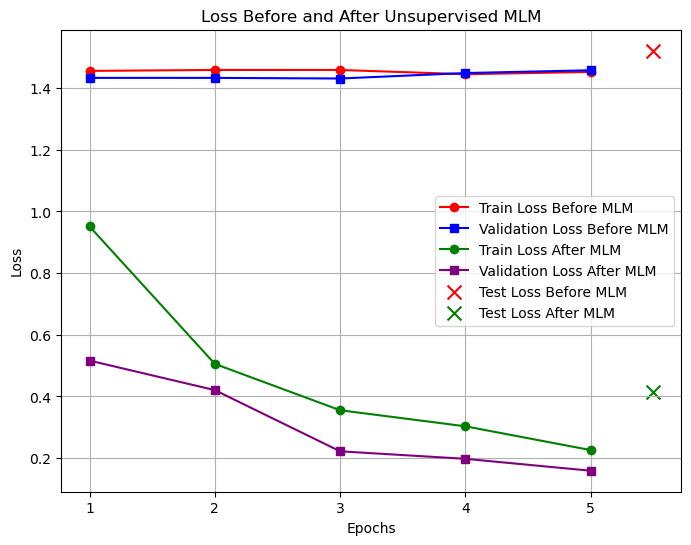

Plot saved as loss_comparison_before_after_MLM.png


In [322]:
import matplotlib.pyplot as plt

# Data
train_loss_before = [1.4559, 1.4589, 1.4589, 1.4451, 1.4525]
val_loss_before = [1.4332, 1.4332, 1.4312, 1.4489, 1.4579]
test_loss_before = [1.5213]

train_loss_after = [0.9512, 0.5055, 0.3552, 0.3031, 0.2260]
val_loss_after = [0.5162, 0.4204, 0.2220, 0.1976, 0.1590]
test_loss_after = [0.4137]

epochs = range(1, 6)

# Plot training and validation loss before and after unsupervised MLM
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_before, 'o-', label="Train Loss Before MLM", color='red')
plt.plot(epochs, val_loss_before, 's-', label="Validation Loss Before MLM", color='blue')
plt.plot(epochs, train_loss_after, 'o-', label="Train Loss After MLM", color='green')
plt.plot(epochs, val_loss_after, 's-', label="Validation Loss After MLM", color='purple')

# Add test losses
plt.scatter([5.5], test_loss_before, color='red', marker='x', s=100, label="Test Loss Before MLM")
plt.scatter([5.5], test_loss_after, color='green', marker='x', s=100, label="Test Loss After MLM")

# Labels and Title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Before and After Unsupervised MLM")
plt.legend()
plt.grid(True)

# Save the plot
plot_filename = "loss_comparison_before_after_MLM.png"
plt.savefig(plot_filename, dpi=300)
plt.show()

print(f"Plot saved as {plot_filename}")